<a href="https://colab.research.google.com/github/VaLMalfoy/HW7_Kolyshkina_pub/blob/main/HW7_Kolyshkina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset from: https://www.nature.com/articles/s41467-020-17890-2/ Zhou, X., Zhong, S., Peng, H. et al. **Cellular and molecular properties of neural progenitors in the developing mammalian hypothalamus**. Nat Commun 11, 4063 (2020). https://doi.org/10.1038/s41467-020-17890-2

In [ ]:
# Loading the packages

!pip install scanpy
!pip install harmonypy
!pip install leidenalg

# Dowload the data

!wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3330nnn/GSM3330882/suppl/GSM3330882_GW10-Hy_barcodes.tsv.gz
!wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3330nnn/GSM3330882/suppl/GSM3330882_GW10-Hy_genes.tsv.gz
!wget ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3330nnn/GSM3330882/suppl/GSM3330882_GW10-Hy_matrix.mtx.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-05-25 04:34:08--  ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3330nnn/GSM3330882/suppl/GSM3330882_GW10-Hy_barcodes.tsv.gz
           => ‘GSM3330882_GW10-Hy_barcodes.tsv.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 130.14.250.12
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/samples/GSM3330nnn/GSM3330882/suppl ... done.
==> SIZE GSM3330882_GW10-Hy_barcodes.tsv.gz ... 28905
==> PASV ... done.    ==> RETR GSM3330882_GW10-Hy_barcodes.tsv.gz ... done.
Length: 28905 (28K) (unauthoritative)

GSM3330882_GW10-Hy

In [ ]:
# Import pakages

import os
import scanpy as sc
import scanpy.external as sce

In [ ]:
# Small organization process

os.mkdir('GW10-Hy')

os.replace("GSM3330882_GW10-Hy_barcodes.tsv.gz", "GW10-Hy/GSM3330882_GW10-Hy_barcodes.tsv.gz")
os.replace("GSM3330882_GW10-Hy_genes.tsv.gz", "GW10-Hy/GSM3330882_GW10-Hy_genes.tsv.gz")
os.replace("GSM3330882_GW10-Hy_matrix.mtx.gz", "GW10-Hy/GSM3330882_GW10-Hy_matrix.mtx.gz")

In [ ]:
#make decompression of files, because files processed by Cellranger version 2 (genes instead of features)
os.mkdir('GW10-Hy_d')
import shutil
import gzip
for file in os.listdir("GW10-Hy"):
  if file.endswith(".gz"):
    gz_path = os.path.join("GW10-Hy", file)
    extract_path = os.path.join("GW10-Hy_d", file.replace(".gz", ""))
    with gzip.open(gz_path, "rb") as infile, open(extract_path, "wb") as outfile:
      shutil.copyfileobj(infile, outfile)

In [ ]:
# Load UMI raw matrices to anndata objects

data = sc.read_10x_mtx(path='GW10-Hy_d', prefix='GSM3330882_GW10-Hy_')

In [ ]:
# Let's calculate quality metrics

data.var['MT'] = data.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(data, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

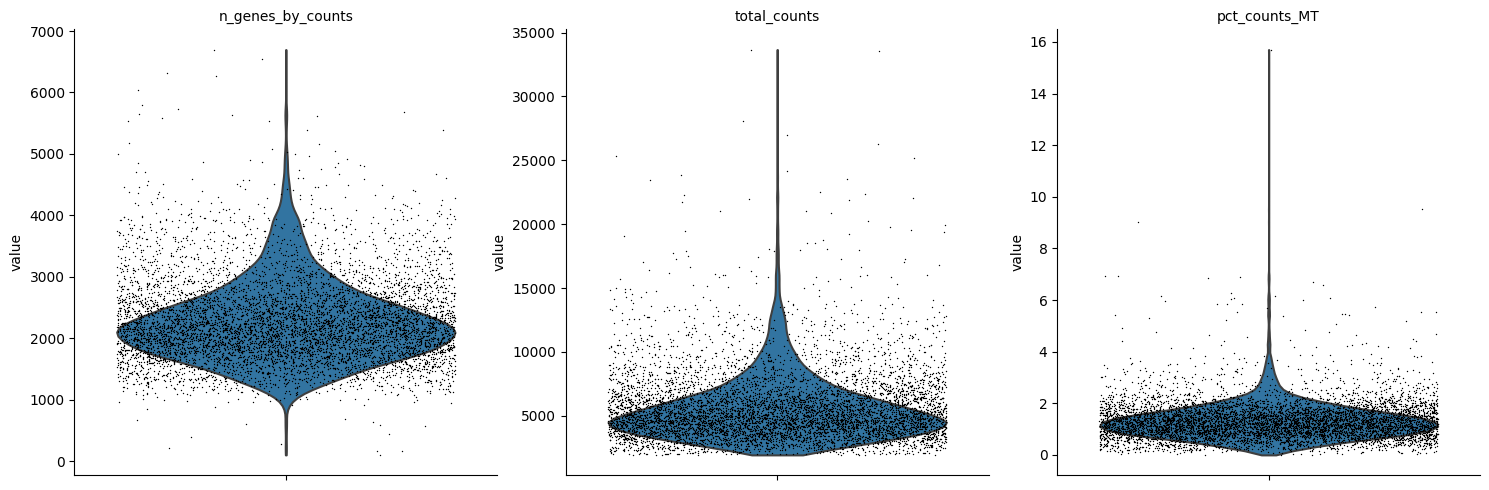

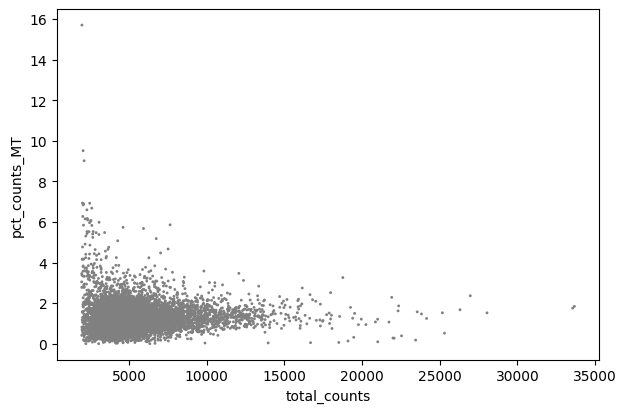

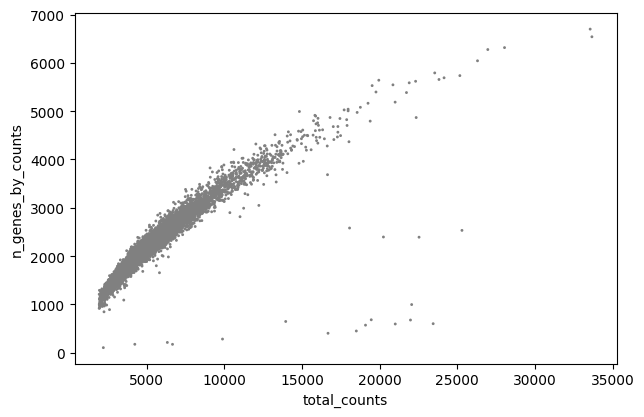

In [ ]:
# And look at them

sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)

sc.pl.scatter(data, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(data, x='total_counts', y='n_genes_by_counts')

**What thresholds you would choose to remove doublet cells?**

In [ ]:
sc.pp.filter_cells(data, min_genes=800)
sc.pp.filter_genes(data, min_cells=7)

data = data[data.obs.pct_counts_MT < 3.5, :]

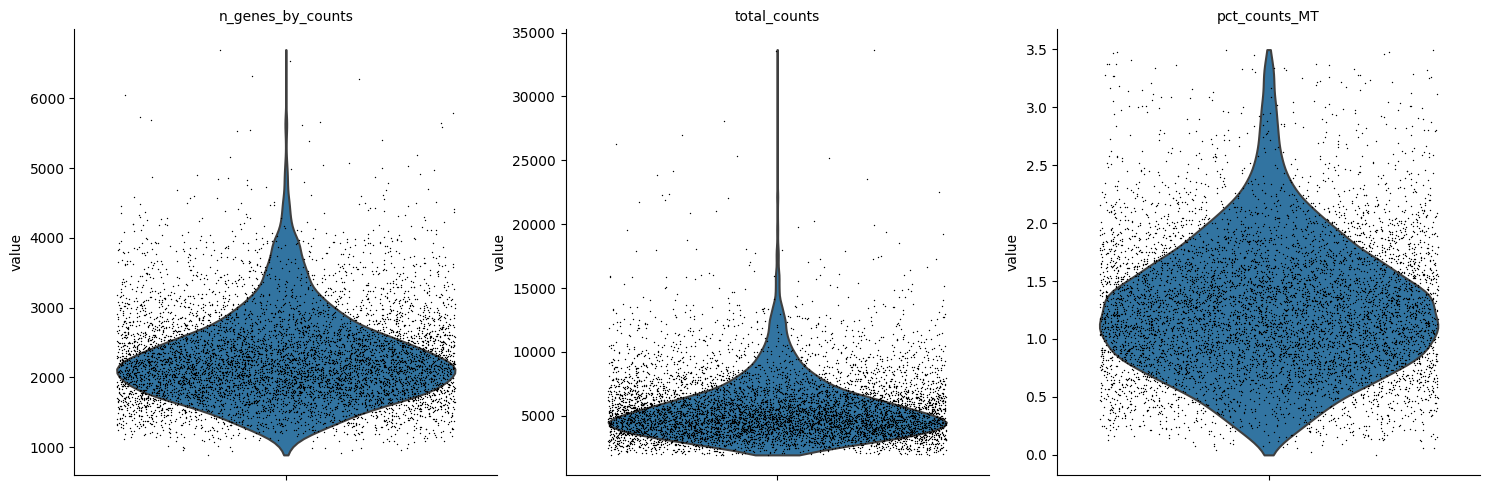

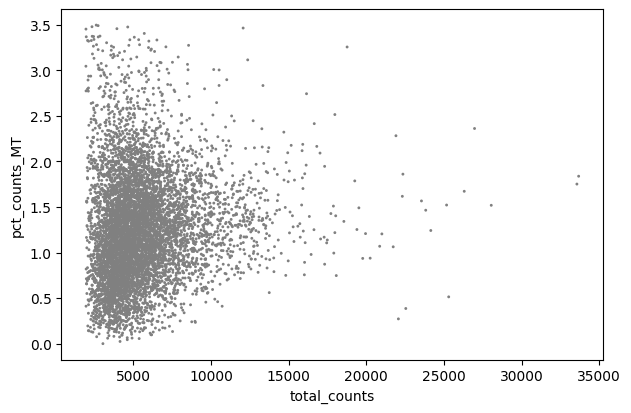

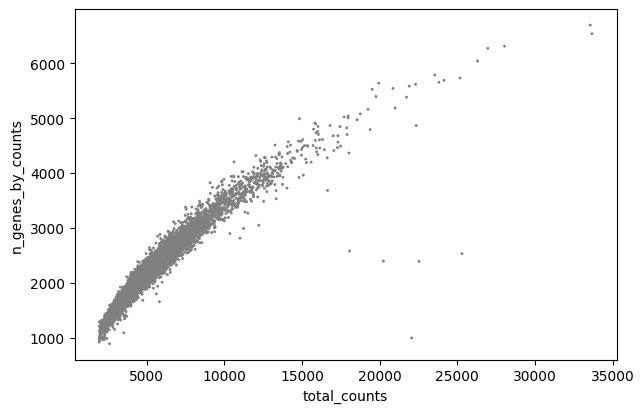

In [ ]:
# Look after filtering

sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)

sc.pl.scatter(data, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(data, x='total_counts', y='n_genes_by_counts')

In [ ]:
# Normalizing the data

sc.pp.normalize_total(data, target_sum=1e4)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
sc.pp.log1p(data)

In [ ]:
# Choosing HVGs

sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)

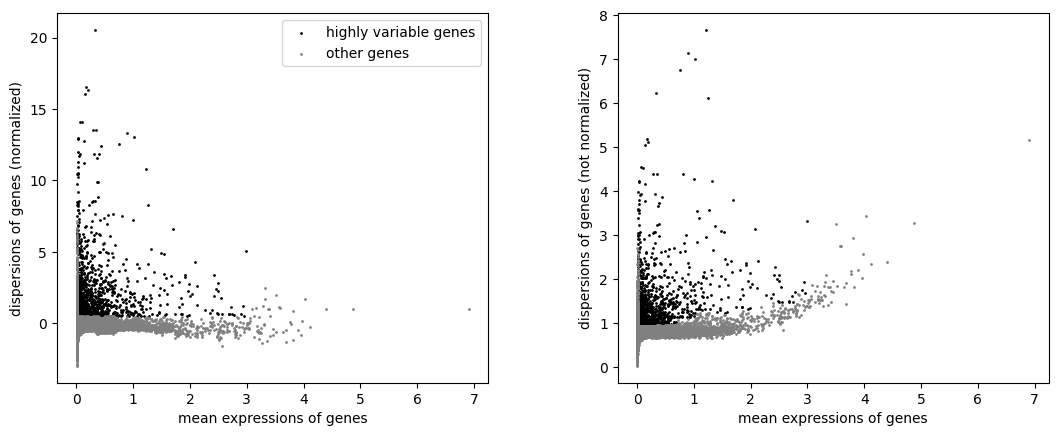

In [ ]:
# Use this plot to see how the HVGs were chosen

sc.pl.highly_variable_genes(data)

In [ ]:
# Exact number of HVGs that I have in the data

data.var.highly_variable.value_counts()

False    16104
True      1281
Name: highly_variable, dtype: int64

In [ ]:
# Saving normalized data before subset

data.raw = data

In [ ]:
# Subset only HVGs for dim reduction

data = data[:, data.var.highly_variable]

In [ ]:
# Scaling the data (Z-score normalization)

sc.pp.scale(data, max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
# PCA 

sc.tl.pca(data)

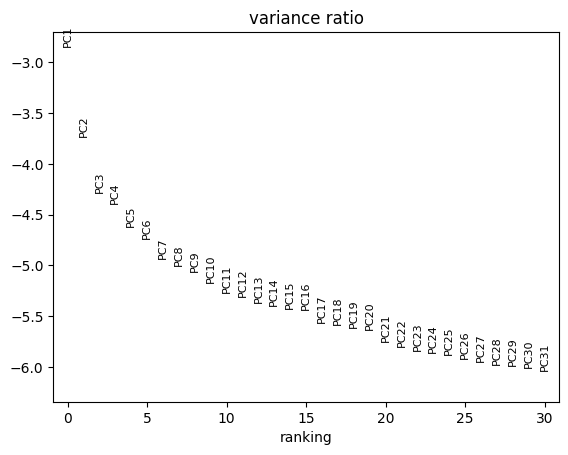

In [ ]:
# Elbow plot to choose number of PCs for UMAP

sc.pl.pca_variance_ratio(data, log=True)

In [ ]:
# Building the UMAP (2 steps)

sc.pp.neighbors(data, n_pcs=20, metric='cosine')

In [ ]:
sc.tl.umap(data)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


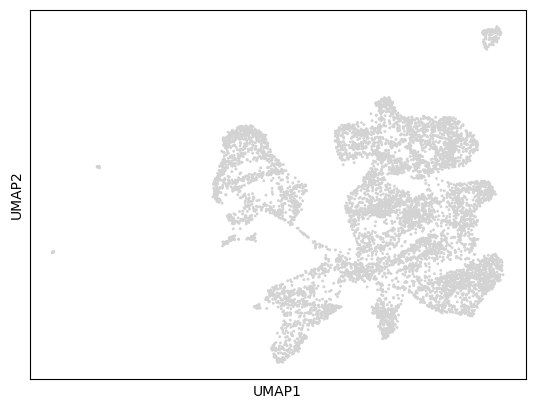

In [ ]:
sc.pl.umap(data)

In [ ]:
# Let's cluster the data!

sc.tl.leiden(data,  resolution=0.5)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


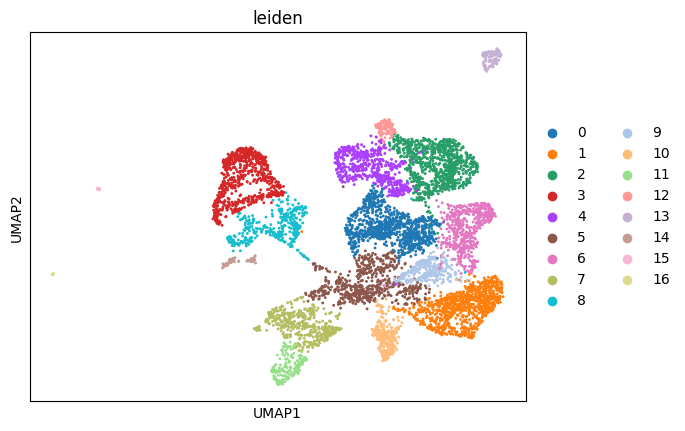

In [ ]:
# And look at the clusters

sc.pl.umap(data, color=['leiden'])

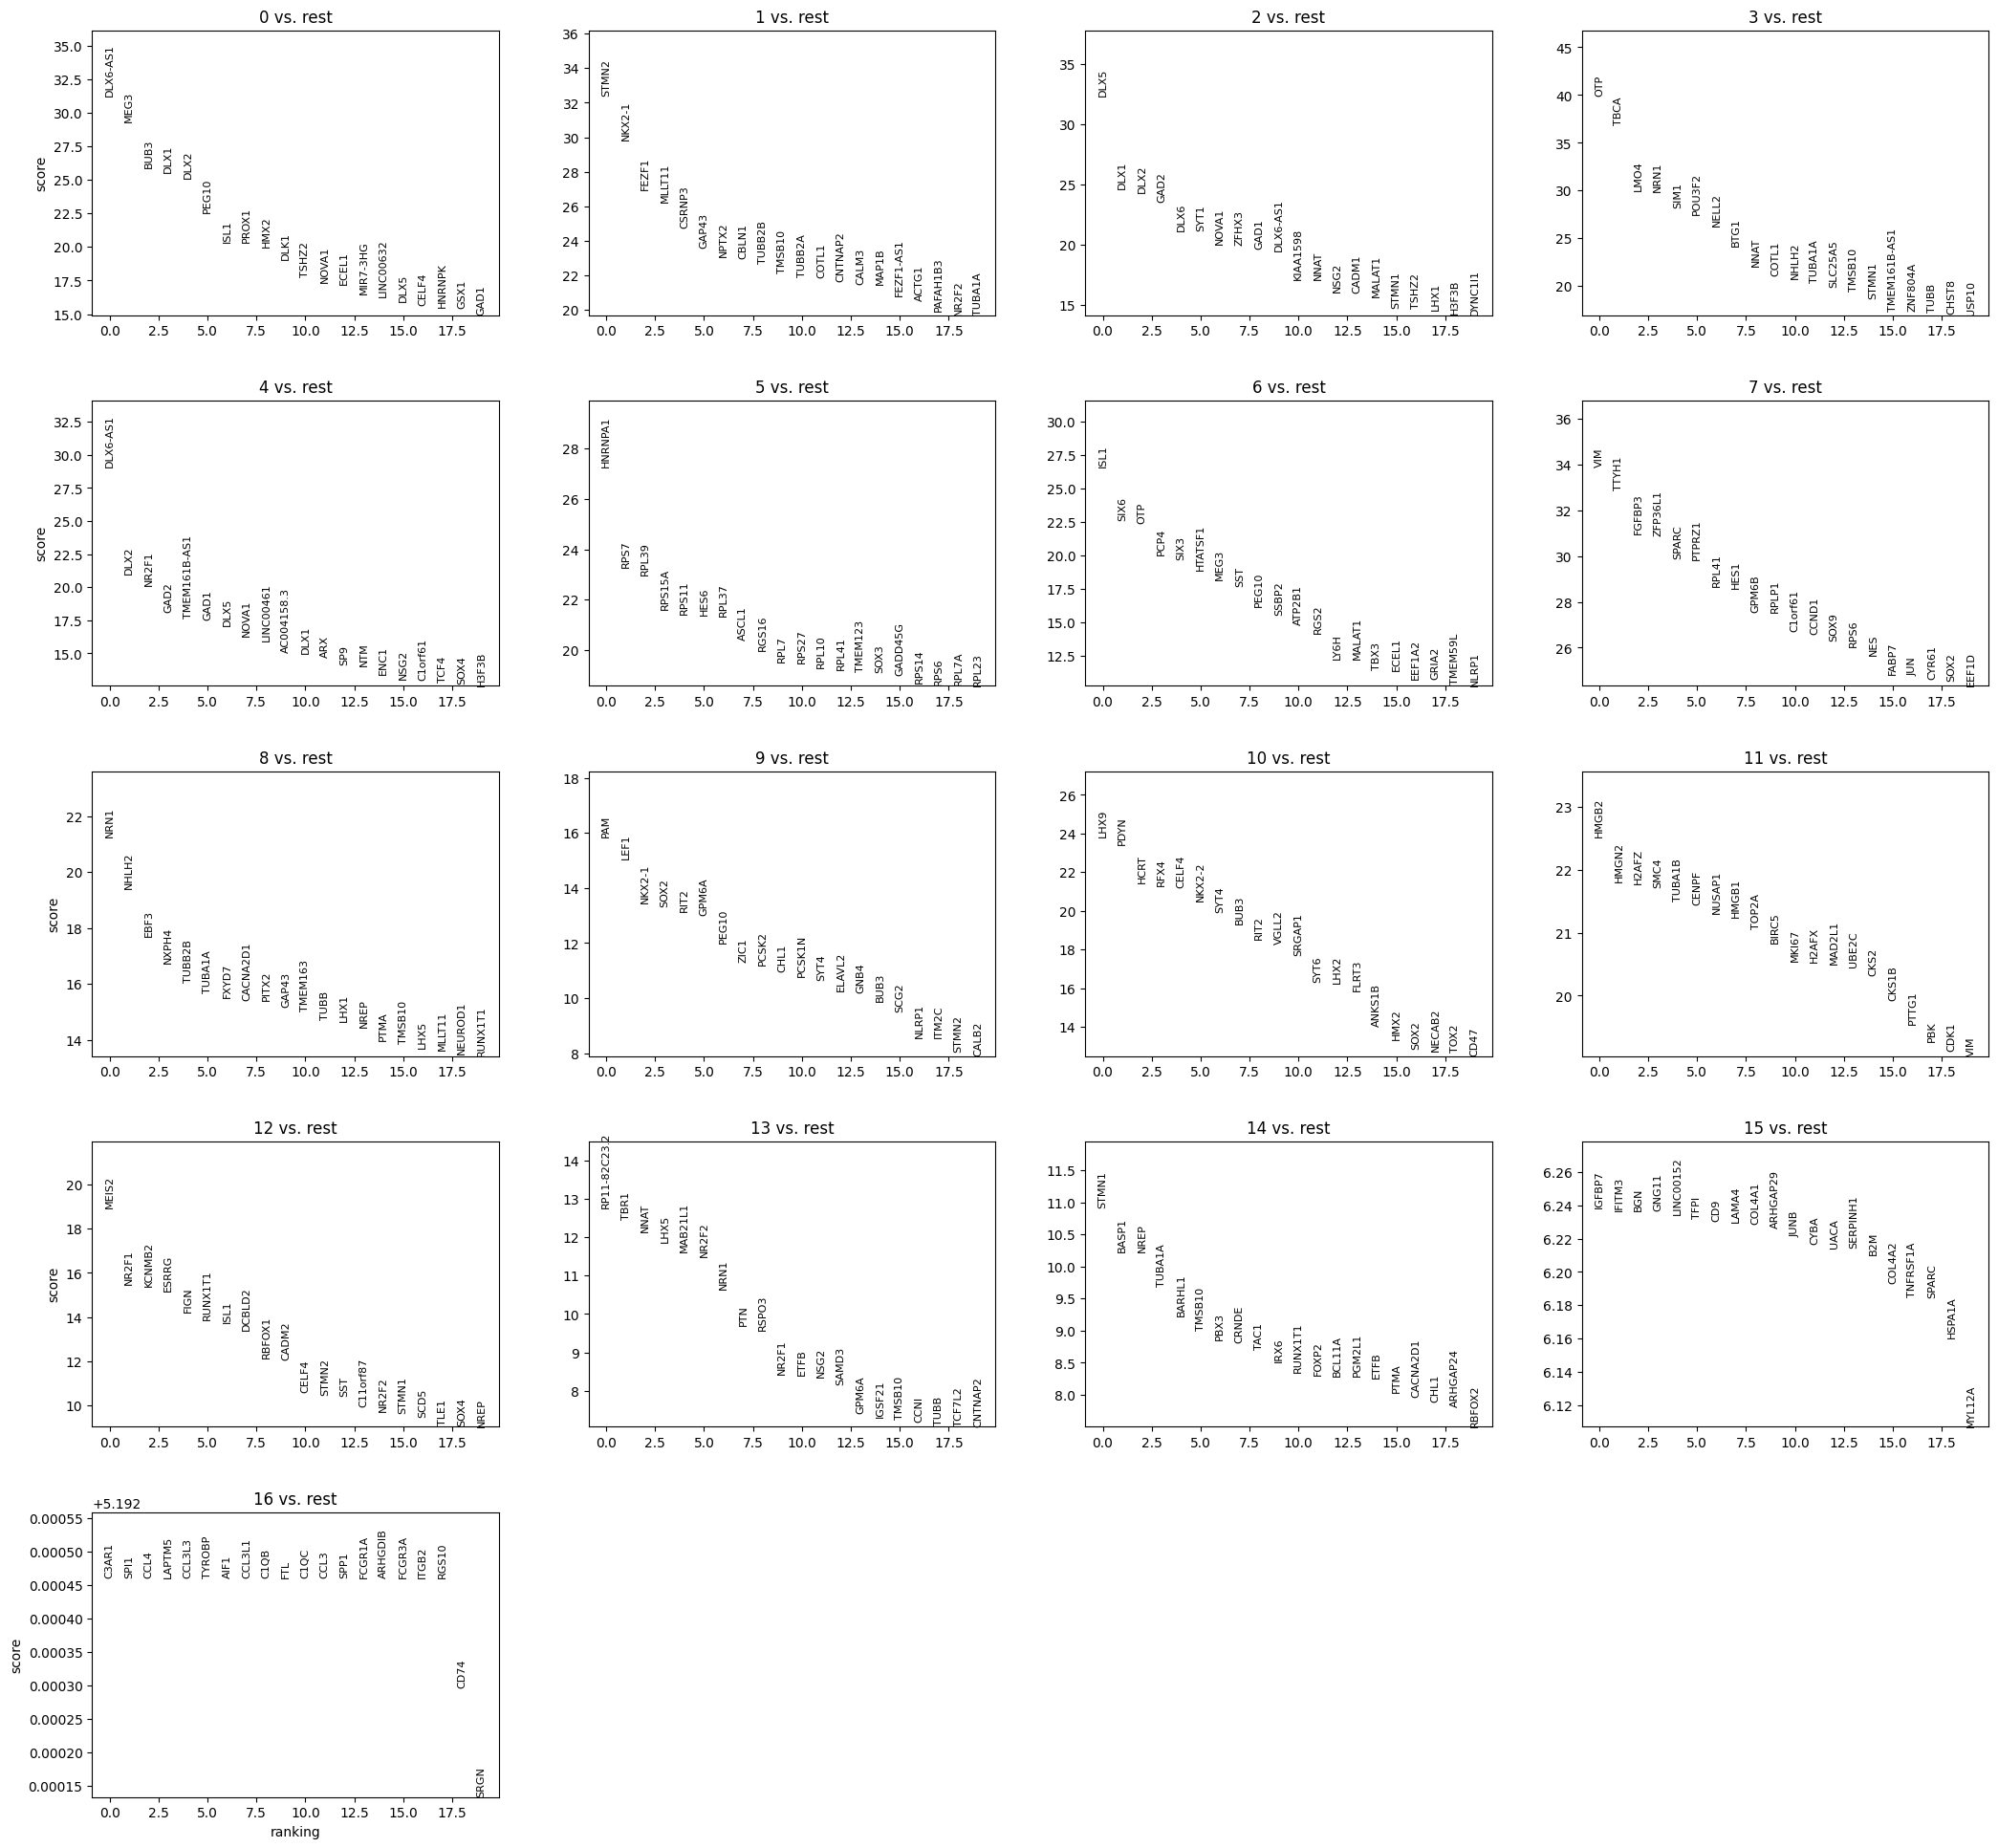

In [ ]:
# Differential expression between the clusters

sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(data, n_genes=20, sharey=False)

In [ ]:
sc.get.rank_genes_groups_df(data, group=['10']).head(n=10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,LHX9,23.822544,8.386533,1.950592e-125,3.391105e-121
1,PDYN,23.417904,7.437976,2.808350e-121,2.441158e-117
2,HCRT,21.472399,7.774584,2.820739e-102,1.634618e-98
3,RFX4,21.278450,4.417781,1.797855e-100,7.813928e-97
4,CELF4,21.206749,2.085595,8.273862e-100,2.876822e-96
5,NKX2-2,20.522488,3.729774,1.355915e-93,3.928765e-90
6,SYT4,19.916506,3.162560,2.927208e-88,7.269929e-85
7,BUB3,19.318331,2.371223,3.766274e-83,8.184585e-80
8,RIT2,18.510159,3.445238,1.709955e-76,3.303062e-73
9,VGLL2,18.267904,5.340656,1.490655e-74,2.591503e-71


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


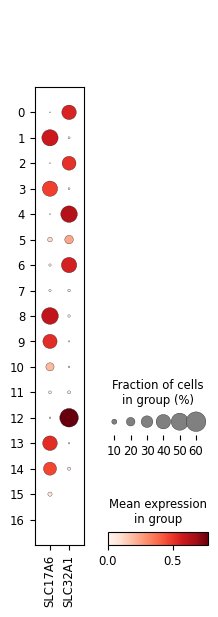

In [ ]:
#markers from the paper
marker_genes = ['SLC17A6','SLC32A1']
sc.pl.dotplot(data, marker_genes, groupby='leiden')

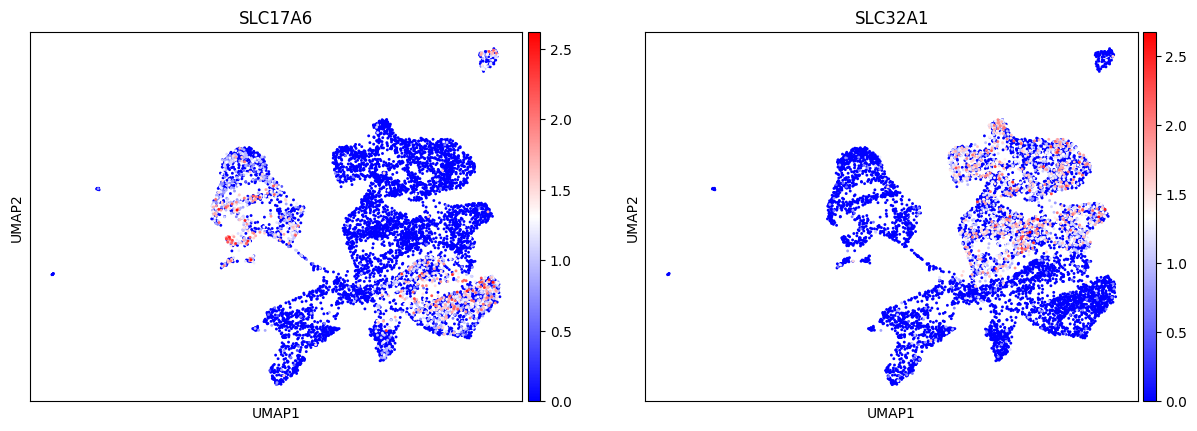

In [ ]:
sc.pl.umap(data, color=marker_genes, color_map='bwr')

I have done the same preparation of data min.cells = 7, min.features(genes) = 800, by the genes in the article - the presence of either SLC17A6 or SLC32A1 defined glutamatergic and GABAergic neurons, respectively. Other cells are in HPC (hypothalamic progenitor cell) cluster. In the article t-SNE clustering was perfomed while I used UMAP. The results are quiet different.
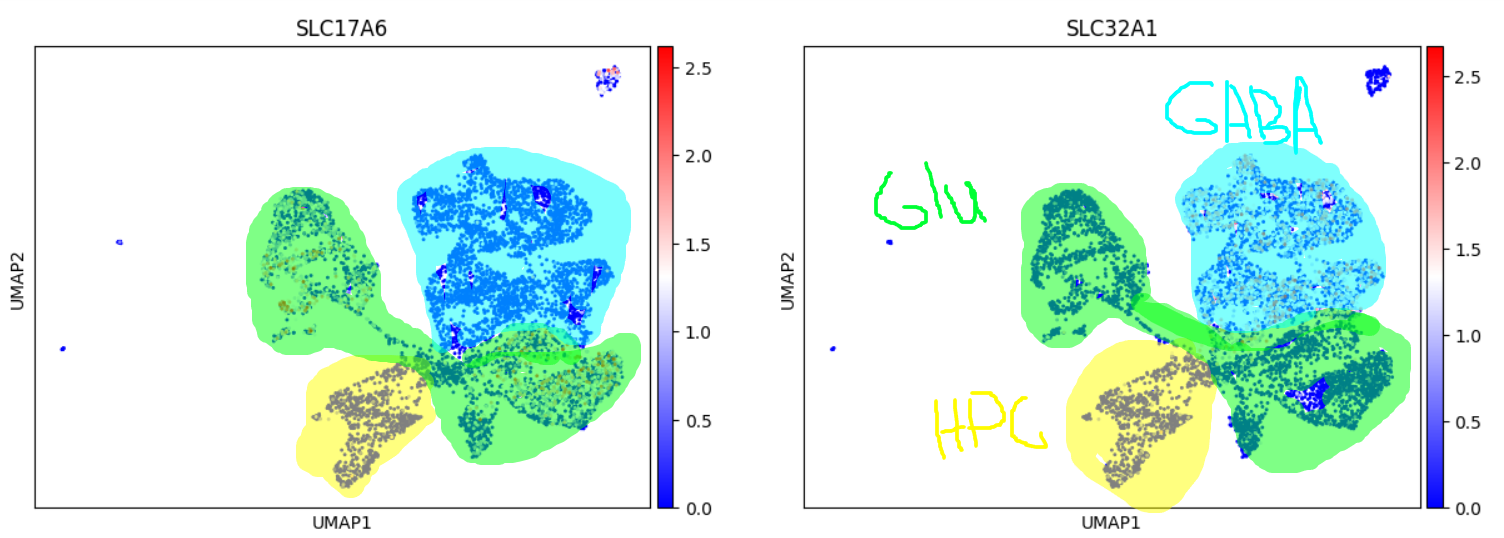

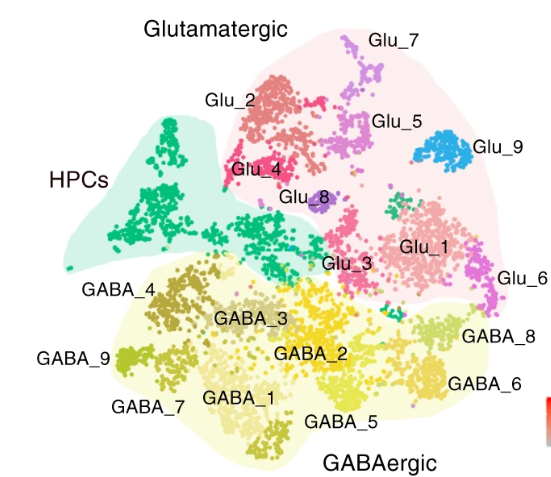